**Import Libraries**

In [339]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

**Import datasets**

In [341]:
# GitHub URLs for each dataset
phys_url = "https://raw.githubusercontent.com/bachphamm/da401/main/NBA_draft_combine.csv"
reg_url = "https://raw.githubusercontent.com/bachphamm/da401/main/average.parq"
adv_9422_url = "https://raw.githubusercontent.com/bachphamm/da401/main/advanced.parq"
adv_2023_url = "https://raw.githubusercontent.com/bachphamm/da401/main/2023_adv.csv"

# Load datasets from GitHub
phys = pd.read_csv(phys_url)
reg = pd.read_parquet(reg_url)
adv_9422 = pd.read_parquet(adv_9422_url)
adv_2023 = pd.read_parquet(adv_2023_url)

**EDA**

*Data Processing*

In [342]:
# Replace the incorrect weight value for Randall Orr
phys.loc[phys['PLAYER'] == 'Orr, Randall', 'WGT'] = 193.0

# Filter the dataset to include only rows where 'YEAR' is between 2003 and 2023
phys = phys[(phys['YEAR'] >= 2003) & (phys['YEAR'] <= 2023)]

# Change name formatting
phys['PLAYER'] = phys['PLAYER'].str.replace(r'^(.*), (.*)$', r'\2 \1', regex=True)

# Select the relevant columns for clustering and convert to numeric
phys['WGT'] = pd.to_numeric(phys['WGT'], errors='coerce')  # Explicitly converting to numeric
phys['HGT'] = pd.to_numeric(phys['HGT'], errors='coerce')
phys['WNGSPN'] = pd.to_numeric(phys['WNGSPN'], errors='coerce')
phys['LPVERT'] = pd.to_numeric(phys['LPVERT'], errors='coerce')
phys['SPRINT'] = pd.to_numeric(phys['SPRINT'], errors='coerce')

# #Drop rows with missing values
phys = phys.dropna()

# Select relevant physical and dynamic traits 
rel_traits = ['HGT', 'WGT', 'WNGSPN', 'LPVERT', 'SPRINT']

# Get specific traits
traits = phys[rel_traits].copy()

In [344]:
# Rename "team_retcon"
adv_9422 = adv_9422.rename(columns={'team_retcon': 'Team'})

# Convert "season" to the correct "Year" by extracting the start year and subtracting 1
adv_9422['Year'] = adv_9422['season'].apply(lambda x: str(int(x.split('/')[0]) - 1))

# Drop the old "season" column if no longer needed
adv_9422 = adv_9422.drop(columns=['season', 'Rk', 'Unnamed: 17', 'Unnamed: 22', 'team'])

# Reorder columns to make "Year" the first column
adv_9422 = adv_9422[['Year'] + [col for col in adv_9422.columns if col != 'Year']]

In [345]:
# Add column 'Year' with value 2023
adv_2023['Year'] = 2023

# Reorganize columns
adv_2023 = adv_2023[adv_9422.columns]

In [346]:
# Merge old statistics with new ones
unfiltered_adv = pd.concat([adv_9422, adv_2023], ignore_index=True)

In [347]:
adv = unfiltered_adv[unfiltered_adv['Player'].isin(phys['PLAYER'])]
adv = adv.dropna()

*Physical and Dynamic Trait Distribution*

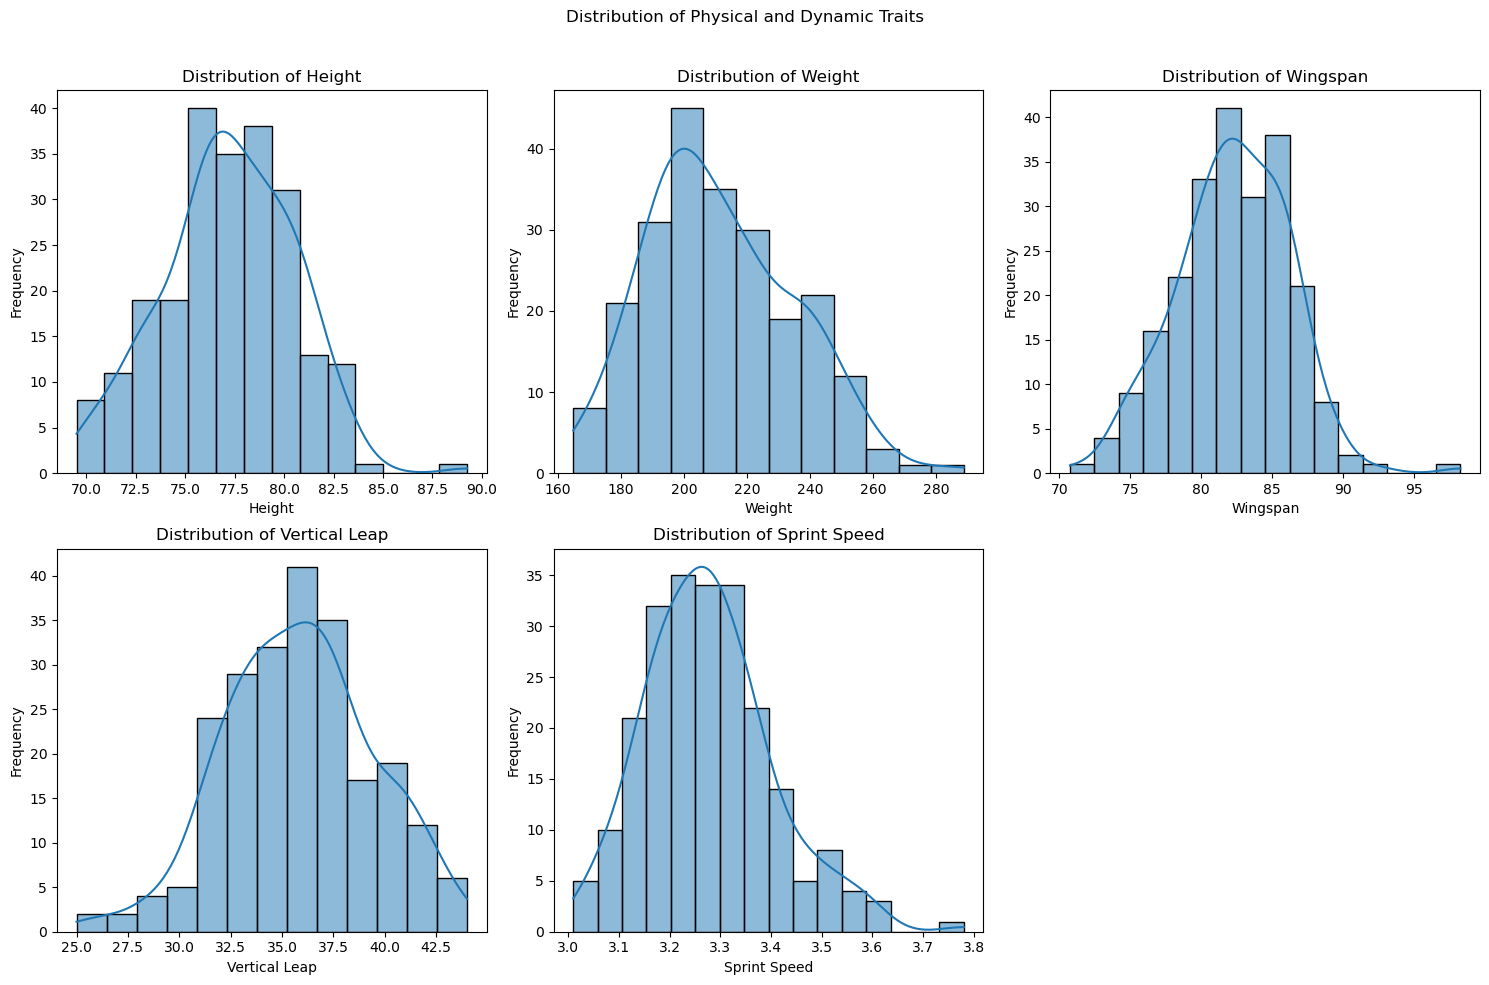

In [348]:
# Set up the figure and axes for a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Distribution of Physical and Dynamic Traits")

# Flatten axes for easy iteration
axes = axes.ravel()

# Define custom titles for each trait
custom_titles = {
    'HGT': 'Height',
    'WGT': 'Weight',
    'WNGSPN': 'Wingspan',
    'LPVERT': 'Vertical Leap',
    'SPRINT': 'Sprint Speed'
}

# Plot each trait's distribution
for i, trait in enumerate(traits.columns):
    sns.histplot(traits[trait], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {custom_titles.get(trait, trait)}')
    axes[i].set_xlabel(custom_titles.get(trait, trait))
    axes[i].set_ylabel('Frequency')

# Remove the last empty subplot if exists
for j in range(len(traits.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust layout to make room for the main title
plt.show()

*Standardize Physical and Dynamic Trait Data*

In [349]:
# Standardize the data to z-scores
scaler = StandardScaler()
z_traits = scaler.fit_transform(traits)

*Multicollinearity Check*

In [350]:

# Calculate VIF for each feature to check for multicollinearity
vif_data = pd.DataFrame()
vif_data['Feature'] = traits.columns
vif_data['VIF'] = [variance_inflation_factor(z_traits, i) for i in range(z_traits.shape[1])]

# Display the VIF data
print(vif_data)

  Feature       VIF
0     HGT  3.987475
1     WGT  2.702919
2  WNGSPN  3.490041
3  LPVERT  1.801965
4  SPRINT  2.043460


**Statistical Analysis**

*Two-step Cluster (Log-likelihood and Schwarz's Bayesisan Information Criteria)*

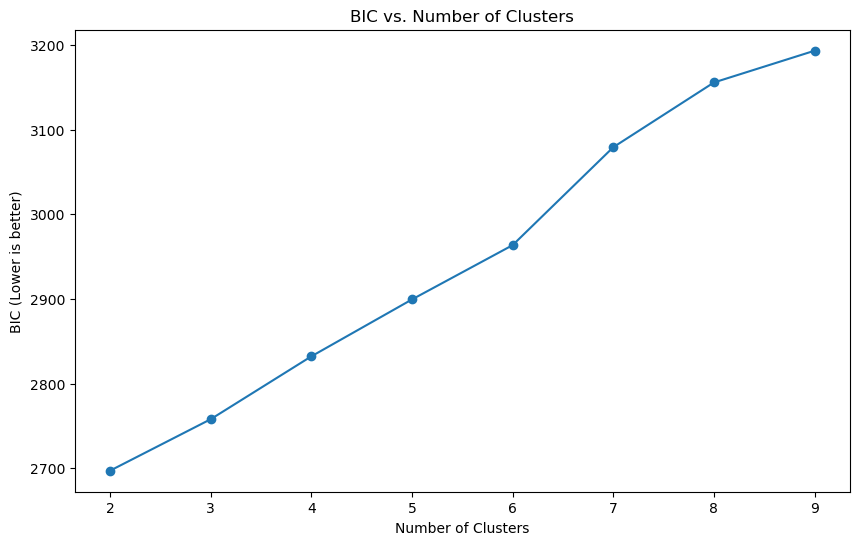

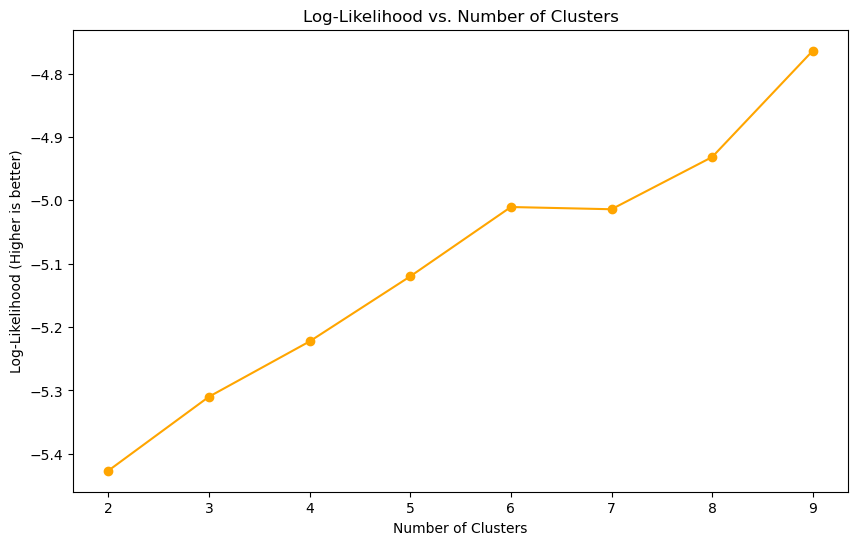

In [351]:
# Run Gaussian Mixture Model with different numbers of clusters and calculate BIC
n_clusters0 = range(2, 10)  # Try different cluster numbers
bics = []
log_likelihoods = []

for n in n_clusters0:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(z_traits)
    bics.append(gmm.bic(z_traits))  # Schwarz criterion (BIC)
    log_likelihoods.append(gmm.score(z_traits))  # Log-likelihood

# Plot BIC values to find the optimal number of clusters (Elbow method)
plt.figure(figsize=(10, 6))
plt.plot(n_clusters0, bics, marker='o')
plt.title("BIC vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC (Lower is better)")
plt.show()

# Plot Log-Likelihood values for reference
plt.figure(figsize=(10, 6))
plt.plot(n_clusters0, log_likelihoods, marker='o', color='orange')
plt.title("Log-Likelihood vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Log-Likelihood (Higher is better)")
plt.show()

*Clusters Validation (Elbow and Silhouette)*

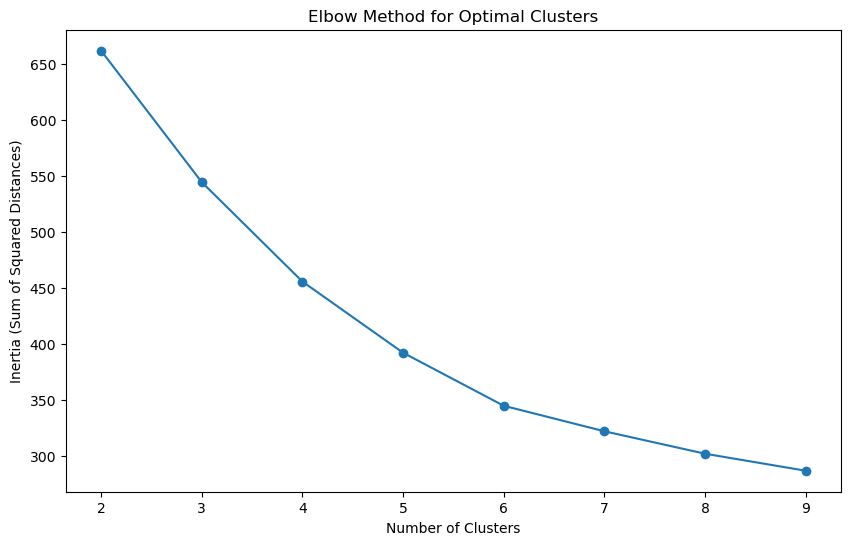

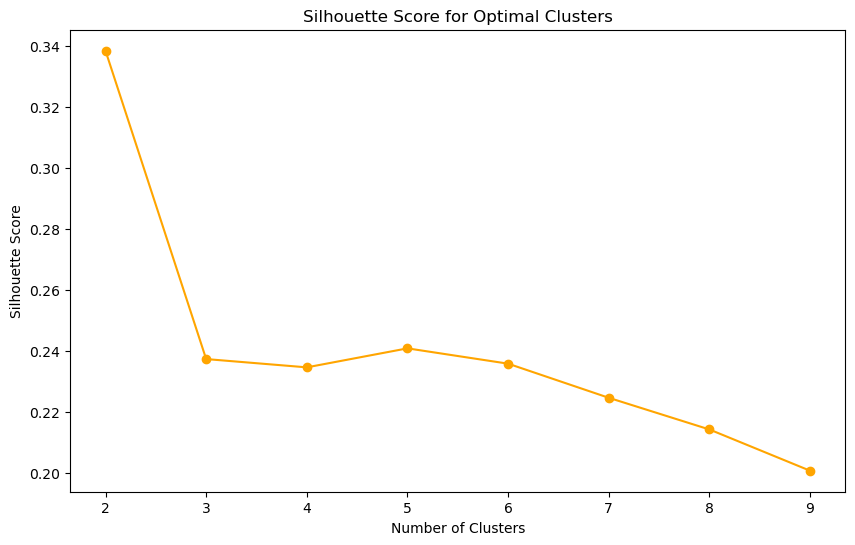

In [352]:
# Range of clusters to evaluate
n_clusters1 = range(2, 10)  # Starting from 2 clusters as 1 cluster won't be meaningful for silhouette scores

# Lists to store evaluation metrics
inertia = []  # For elbow method
silhouette_scores = []  # For silhouette score

# Calculate inertia and silhouette score for each cluster count
for n in n_clusters1:
    kmeans = KMeans(n_clusters=n, n_init='auto', random_state=42)
    kmeans.fit(z_traits)
    
    # Append inertia (for elbow method)
    inertia.append(kmeans.inertia_)
    
    # Append silhouette score (only if n > 1, as silhouette score requires >1 clusters)
    silhouette_avg = silhouette_score(z_traits, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot the elbow method result
plt.figure(figsize=(10, 6))
plt.plot(n_clusters1, inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.show()

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters1, silhouette_scores, marker='o', color='orange')
plt.title("Silhouette Score for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()


In [353]:
# Apply KMeans with 2 clusters
kmeans_2 = KMeans(n_clusters=2, n_init='auto', random_state=42)
kmeans_2.fit(z_traits)
traits['2_Cluster'] = kmeans_2.labels_

# Add cluster labels back to the original DataFrame
phys['2_Cluster'] = None
phys.loc[traits.index, '2_Cluster'] = traits['2_Cluster']

# Now try calculating mean values for each cluster
print("Characteristics of 2-Cluster Solution")
print(phys.groupby('2_Cluster')[['HGT', 'WGT', 'WNGSPN', 'LPVERT', 'SPRINT']].mean())

Characteristics of 2-Cluster Solution
                 HGT         WGT     WNGSPN     LPVERT    SPRINT
2_Cluster                                                       
0          79.804245  228.916038  85.271226  34.018868  3.354434
1          74.961066  195.959016  79.625000  37.393443  3.210738


In [354]:
# Rename columns
og_names = ['YEAR', 'PLAYER', 'POS', 'HGT', 'WGT', 'WNGSPN', 'LPVERT', 'SPRINT']
new_names = ['Year', 'Player', 'Position', 'Height', 'Weight', 'Wingspan', 'Vertical', 'Sprint']

# DataFrames for each cluster, selecting only the original names and renaming them
traits_0 = phys[phys['2_Cluster'] == 0][og_names].copy()
traits_0.columns = new_names  # Apply new names to c0

traits_1 = phys[phys['2_Cluster'] == 1][og_names].copy()
traits_1.columns = new_names  # Apply new names to c1

In [355]:
traits_test = phys[og_names].copy()
traits_test.columns = new_names

In [356]:
traits_test

,Year,Player,Position,Height,Weight,Wingspan,Vertical,Sprint
304,2019,Darius Bazley,PF,79.75,208.4,84.00,37.0,3.27
306,2019,Jordan Bone,SG,73.50,179.0,75.25,42.5,3.08
307,2019,Brian Bowen II,SF,78.25,200.0,82.00,35.5,3.26
308,2019,Ky Bowman,PG,73.00,181.2,79.00,33.0,3.26
309,2019,Ignas Brazdeikis,SF,77.75,220.8,81.25,36.5,3.36
...,...,...,...,...,...,...,...,...
708,2013,James Southerland,SF-PF,79.00,220.6,85.00,32.0,3.38
709,2013,Adonis Thomas,SF,76.75,231.8,85.00,40.5,3.32
710,2013,Deshaun Thomas,SF,77.00,219.8,82.00,32.0,3.53
711,2013,Jeff Withey,C,82.75,221.8,86.00,29.0,3.47


In [357]:
traits_0.head()

,Year,Player,Position,Height,Weight,Wingspan,Vertical,Sprint
304,2019,Darius Bazley,PF,79.75,208.4,84.00,37.0,3.27
309,2019,Ignas Brazdeikis,SF,77.75,220.8,81.25,36.5,3.36
310,2019,O'Shae Brissett,SF-PF,79.00,203.2,84.00,37.5,3.48
313,2019,Nicolas Claxton,C,82.00,216.6,86.50,36.5,3.36
314,2019,Tyler Cook,PF,79.25,245.4,84.50,32.0,3.28


*Standardize advanced Performance Data*

In [358]:
unfiltered_adv = unfiltered_adv.dropna()

In [359]:
# Create a copy of original dataset
z_adv = adv.copy()

# Select only numeric columns for normalization
metrics = ['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 
           'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48',
           'OBPM', 'DBPM', 'BPM', 'VORP']

# Initialize the scaler and z-score the advanced stats in adv
scaler = StandardScaler()
z_adv[metrics] = scaler.fit_transform(z_adv[metrics])

In [360]:
# Perform PCA
pca = PCA(n_components=0.9)
pca.fit(z_adv[metrics])

# Extract explained variance ratio for each principal component
explained_variance = pca.explained_variance_ratio_

*Two-way Player Score*

In [361]:
# Check Variance
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio)
print("Cumulative explained variance:", explained_variance_ratio.cumsum())

Explained variance ratio: [0.33113523 0.18522985 0.11257097 0.08301991 0.07472799 0.04733986
 0.0389423  0.02924568]
Cumulative explained variance: [0.33113523 0.51636507 0.62893605 0.71195595 0.78668395 0.83402381
 0.87296611 0.90221179]


In [362]:
# Check Loadings
loadings = pd.DataFrame(pca.components_, columns=metrics)  # Use only numeric column names
print(loadings)

        PER       TS%      3PAr       FTr      ORB%      DRB%      TRB%  \
0 -0.351238 -0.294019  0.119757 -0.068718 -0.126892 -0.111498 -0.136015   
1 -0.032205 -0.078021 -0.344263  0.210798  0.390351  0.402953  0.452200   
2  0.184640  0.223407  0.003193 -0.012445  0.094898 -0.074891 -0.009164   
3  0.054092 -0.170569 -0.256622  0.209737  0.051885 -0.103462 -0.048539   
4 -0.225165 -0.114642  0.168463 -0.121528 -0.145644 -0.021188 -0.076822   
5 -0.068645  0.150626 -0.143656  0.763944 -0.019381 -0.337968 -0.236431   
6  0.038407 -0.260942 -0.092520  0.143509  0.313008 -0.149503  0.043521   
7 -0.000819 -0.309302 -0.095416  0.214123 -0.270844 -0.037218 -0.149622   

       AST%      STL%      BLK%      TOV%      USG%       OWS       DWS  \
0 -0.074786 -0.064657 -0.109530  0.032249 -0.081228 -0.281035 -0.253091   
1 -0.227153 -0.050910  0.352302  0.214582 -0.086264 -0.066065 -0.012938   
2  0.066293  0.272879  0.043400  0.055075 -0.184646 -0.385488 -0.335412   
3  0.514183  0.368994 -0

In [363]:
# Select number of components to retain
n_components_to_retain = 8

# Subset the loadings
loadings_subset = loadings.iloc[:n_components_to_retain]

# Aggregate loadings across selected components
feature_weights = loadings_subset.abs().sum(axis=0)

# Normalize to get weights that sum to 1
normalized_weights = feature_weights / feature_weights.sum()

# Create a DataFrame for better readability without redundancy
weights_df = pd.DataFrame({
    'Feature': metrics,         # Use metrics for the 'Feature' column
    'Weight': normalized_weights.values  # Use normalized_weights as the 'Weight'
}).sort_values(by='Weight', ascending=False)

print(weights_df.reset_index(drop=True))

   Feature    Weight
0     TOV%  0.079295
1     STL%  0.072883
2      FTr  0.064770
3     USG%  0.062721
4     BLK%  0.062410
5     AST%  0.060716
6      TS%  0.059451
7     ORB%  0.052449
8     DBPM  0.050431
9     DRB%  0.045982
10    3PAr  0.045433
11    TRB%  0.042776
12      WS  0.040601
13    VORP  0.039693
14    OBPM  0.038985
15     OWS  0.038476
16   WS/48  0.037731
17     DWS  0.037107
18     PER  0.035459
19     BPM  0.032633


In [364]:
# Create a dictionary of weights from weights_df
weights_dict = dict(zip(weights_df['Feature'], weights_df['Weight']))

# Calculate the Two-Way Score (2WS) using the weights
z_adv['2WS'] = z_adv.apply(lambda row: sum(row[metric] * weights_dict[metric] for metric in metrics), axis=1)

In [365]:
# Create datasets for each cluster based on players in c0 and c1
z_adv_0 = z_adv[z_adv["Player"].isin(traits_0["Player"])]
z_adv_1 = z_adv[z_adv["Player"].isin(traits_1["Player"])]

In [366]:
z_adv_test = z_adv[z_adv['Player'].isin(traits_test['Player'])]

*Regression Analysis*

In [367]:
# For traits_0 dataset
traits_0['Weight'] = pd.to_numeric(traits_0['Weight'], errors='coerce')
traits_0['Height'] = pd.to_numeric(traits_0['Height'], errors='coerce')
traits_0['Wingspan'] = pd.to_numeric(traits_0['Wingspan'], errors='coerce')
traits_0['Vertical'] = pd.to_numeric(traits_0['Vertical'], errors='coerce')
traits_0['Sprint'] = pd.to_numeric(traits_0['Sprint'], errors='coerce')

# For traits_1 dataset
traits_1['Weight'] = pd.to_numeric(traits_1['Weight'], errors='coerce')
traits_1['Height'] = pd.to_numeric(traits_1['Height'], errors='coerce')
traits_1['Wingspan'] = pd.to_numeric(traits_1['Wingspan'], errors='coerce')
traits_1['Vertical'] = pd.to_numeric(traits_1['Vertical'], errors='coerce')
traits_1['Sprint'] = pd.to_numeric(traits_1['Sprint'], errors='coerce')

col_list1 = ['Height', 'Weight', 'Wingspan', 'Vertical', 'Sprint']

# Initialize the scaler and z-score the advanced stats in adv
scaler = StandardScaler()
z_traits_0 = traits_0.copy()
z_traits_0[col_list1] = scaler.fit_transform(traits_0[col_list1])
z_traits_1 = traits_1.copy()
z_traits_1[col_list1] = scaler.fit_transform(traits_1[col_list1])

In [368]:
scaler = StandardScaler()
z_traits_test = traits_test.copy()
z_traits_test[col_list1] = scaler.fit_transform(traits_test[col_list1])

In [369]:
# For traits_test dataset
traits_test['Weight'] = pd.to_numeric(traits_test['Weight'], errors='coerce')
traits_test['Height'] = pd.to_numeric(traits_test['Height'], errors='coerce')
traits_test['Wingspan'] = pd.to_numeric(traits_test['Wingspan'], errors='coerce')
traits_test['Vertical'] = pd.to_numeric(traits_test['Vertical'], errors='coerce')
traits_test['Sprint'] = pd.to_numeric(traits_test['Sprint'], errors='coerce')

In [370]:
z_adv_0 = z_adv_0.groupby('Player', as_index=False)['2WS'].mean()
z_adv_1 = z_adv_1.groupby('Player', as_index=False)['2WS'].mean()

In [371]:
# Merge z_adv_0 and z_traits_0 on 'Player', keeping only the players present in z_adv_0
z_reg_0 = pd.merge(z_adv_0, z_traits_0, on='Player', how='left').drop(['Year', 'Position'], axis=1, errors='ignore')
z_reg_1 = pd.merge(z_adv_1, z_traits_1, on='Player', how='left').drop(['Year', 'Position'], axis=1, errors='ignore')

In [372]:
z_reg_test = pd.merge(z_adv_test, z_traits_test, on='Player', how='left').drop(['Year', 'Position'], axis=1, errors='ignore')

In [373]:
z_reg_0

,Player,2WS,Height,Weight,Wingspan,Vertical,Sprint
0,Admiral Schofield,-0.314716,-1.788190,0.627239,-1.333809,-0.006406,0.134271
1,Adonis Thomas,-0.683368,-1.435652,0.154822,-0.102738,2.200578,-0.297024
2,Alan Williams,0.520004,-0.260524,1.743861,0.181355,-1.873855,1.255637
3,Alize Johnson,-0.078704,-0.260524,-0.661171,-1.712601,-1.025015,0.220530
4,Bobby Portis,0.210198,0.797092,0.927868,0.276053,-0.855247,1.773190
...,...,...,...,...,...,...,...
64,Tony Mitchell,0.514089,-0.143011,0.401767,0.465449,1.351738,1.428155
65,Treveon Graham,-0.458382,-1.788190,-0.510857,-1.049716,-0.855247,-0.469541
66,Tyler Cook,0.129729,-0.260524,0.884921,-0.292134,-0.685479,-0.642059
67,Tyler Lydon,-0.253007,0.209528,-0.747065,-0.481529,-0.176174,0.910601


In [374]:
# Define the dependent and independent variables
y = z_reg_0['2WS']  # Two-way score as the target variable
X = z_reg_0[['Height', 'Weight', 'Wingspan', 'Vertical', 'Sprint']]  # Physical traits as predictors

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run the multiple regression on the training set
model = sm.OLS(y_train, X_train).fit()

# Display the regression results for the training set
print("Training Set Results")
print(model.summary())

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics for the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Set Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Training Set Results
                            OLS Regression Results                            
Dep. Variable:                    2WS   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     6.051
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           0.000195
Time:                        22:47:52   Log-Likelihood:                -15.437
No. Observations:                  55   AIC:                             42.87
Df Residuals:                      49   BIC:                             54.92
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0166      0.04

In [375]:
# Define the dependent and independent variables
y = z_reg_0['2WS']  # Two-way score as the target variable
X = z_reg_0[['Height', 'Weight', 'Wingspan', 'Vertical', 'Sprint']]  # Physical traits as predictors

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Split the data into train and test sets (optional if working with all data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Full model: Fit with all predictors
full_model = sm.OLS(y_train, X_train).fit()
full_r2 = full_model.rsquared

# Reduced model: Exclude Height and fit the model
X_reduced = X_train.drop(columns=['Height'])
reduced_model = sm.OLS(y_train, X_reduced).fit()
reduced_r2 = reduced_model.rsquared

# Calculate partial R-squared for Height
partial_r2_height = full_r2 - reduced_r2
percentage_contribution_height = (partial_r2_height / full_r2) * 100

# Print results
print("Full R-squared:", full_r2)
print("Reduced R-squared (without Height):", reduced_r2)
print("Partial R-squared for Height:", partial_r2_height)
print("Percentage Contribution of Height:", percentage_contribution_height, "%")

Full R-squared: 0.3817552710956491
Reduced R-squared (without Height): 0.2635818607534184
Partial R-squared for Height: 0.11817341034223072
Percentage Contribution of Height: 30.955279282213834 %


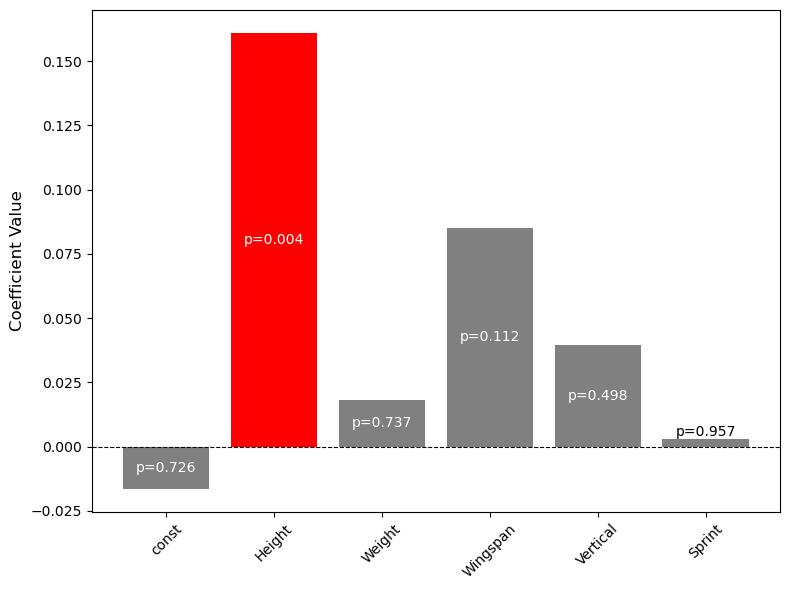

In [376]:
# Extract coefficients and p-values for Cluster 0
coefficients = model.params
p_values = model.pvalues

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(coefficients.index, coefficients, color=['red' if p < 0.05 else 'gray' for p in p_values])
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
# plt.title('Regression Coefficients for Two-Way Score (2WS) - Big Men', fontsize=14)
plt.ylabel('Coefficient Value', fontsize=12)
plt.xticks(rotation=45, fontsize=10)

# Annotate the first 5 bars with p-values in the center
for i, (bar, p_val) in enumerate(zip(bars, p_values)):
    if i < 5:  # First 5 coefficients
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
                 f'p={p_val:.3f}', ha='center', va='center', fontsize=10, color='white')

# Annotate the rest of the bars normally (above or below)
for i, (bar, p_val) in enumerate(zip(bars, p_values)):
    if i >= 5:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'p={p_val:.3f}', ha='center', va='bottom' if bar.get_height() >= 0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()

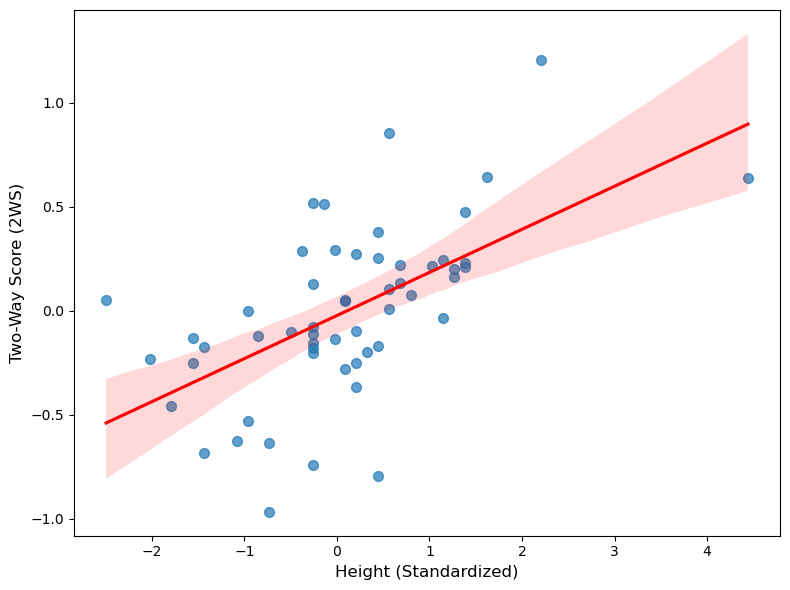

In [377]:
# Scatterplot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x=X_train['Height'], y=y_train, scatter_kws={'s': 50, 'alpha': 0.7}, line_kws={'color': 'red'})
# plt.title('Relationship Between Height and Two-Way Score (2WS) - Big Men', fontsize=14)
plt.xlabel('Height (Standardized)', fontsize=12)
plt.ylabel('Two-Way Score (2WS)', fontsize=12)
plt.tight_layout()
plt.show()

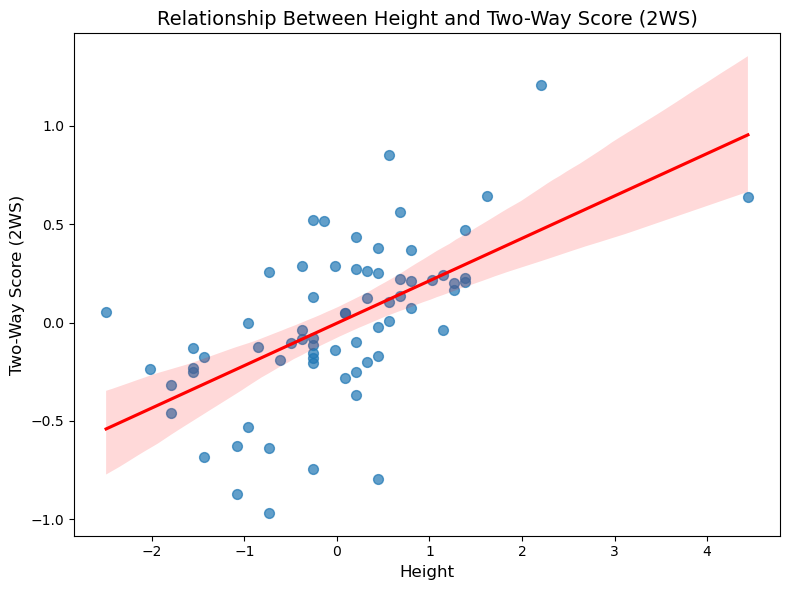

In [378]:
plt.figure(figsize=(8, 6))
sns.regplot(x=X['Height'], y=y, scatter_kws={'alpha': 0.7, 's': 50}, line_kws={'color': 'red'})
plt.title('Relationship Between Height and Two-Way Score (2WS)', fontsize=14)
plt.xlabel('Height', fontsize=12)
plt.ylabel('Two-Way Score (2WS)', fontsize=12)
plt.tight_layout()
plt.show()


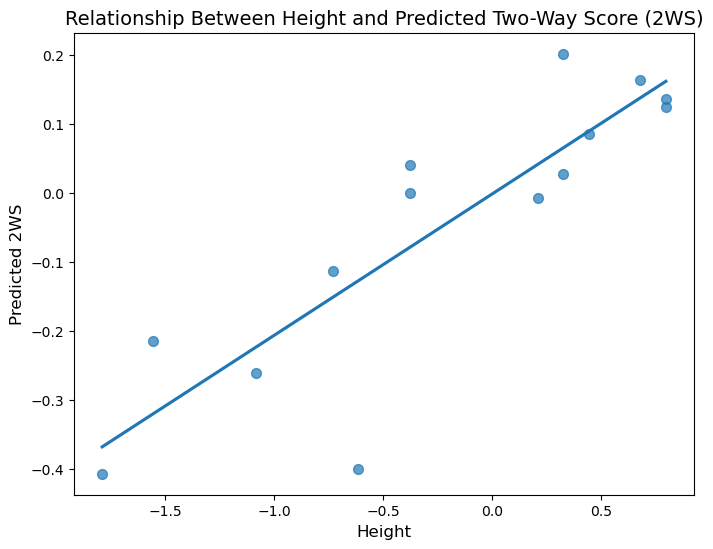

In [379]:
# Single Predictor Scatterplot with Regression Line (Predicted 2WS)
plt.figure(figsize=(8, 6))
sns.regplot(x=X_test['Height'], y=y_pred, scatter_kws={'s': 50, 'alpha': 0.7}, ci=None)
plt.title('Relationship Between Height and Predicted Two-Way Score (2WS)', fontsize=14)
plt.xlabel('Height', fontsize=12)
plt.ylabel('Predicted 2WS', fontsize=12)
plt.show()

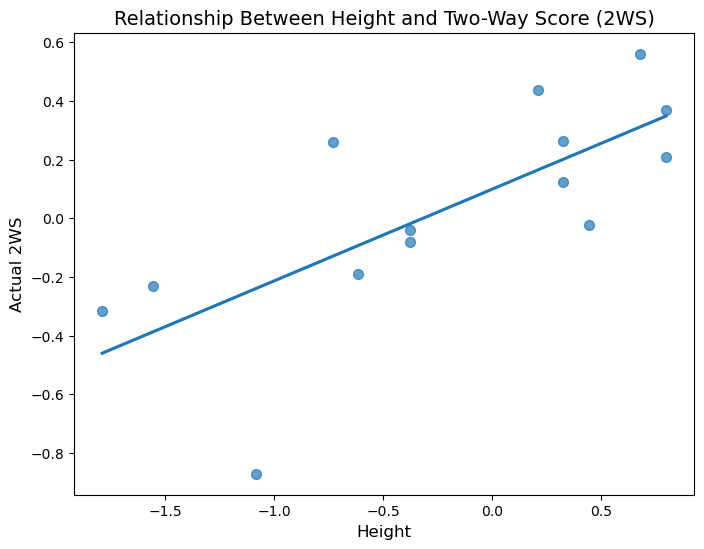

In [380]:
# Single Predictor Scatterplot with Regression Line (e.g., Height)
plt.figure(figsize=(8, 6))
sns.regplot(x=X_test['Height'], y=y_test, scatter_kws={'s': 50, 'alpha': 0.7}, ci=None)
plt.title('Relationship Between Height and Two-Way Score (2WS)', fontsize=14)
plt.xlabel('Height', fontsize=12)
plt.ylabel('Actual 2WS', fontsize=12)
plt.show()

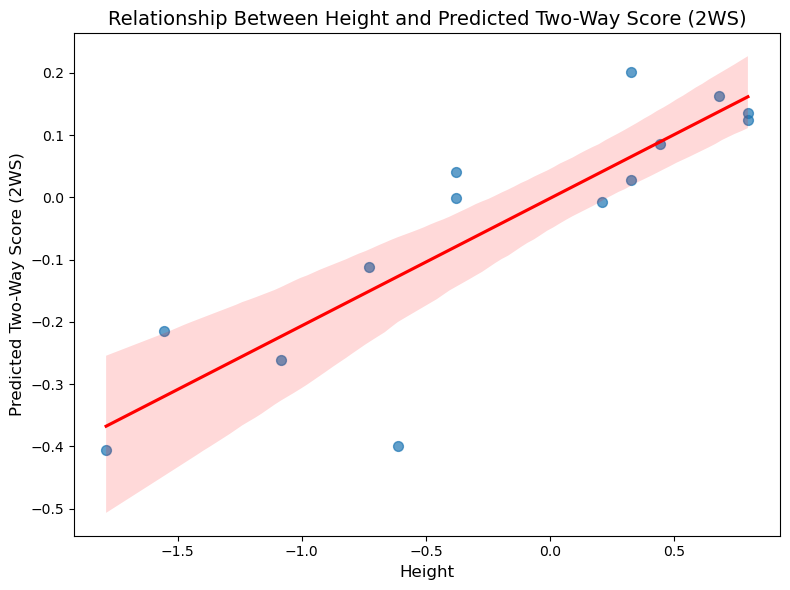

In [381]:
plt.figure(figsize=(8, 6))
sns.regplot(x=X_test['Height'], y=y_pred, scatter_kws={'alpha': 0.7, 's': 50}, line_kws={'color': 'red'})
plt.title('Relationship Between Height and Predicted Two-Way Score (2WS)', fontsize=14)
plt.xlabel('Height', fontsize=12)
plt.ylabel('Predicted Two-Way Score (2WS)', fontsize=12)
plt.tight_layout()
plt.show()


In [382]:
# Define the dependent and independent variables
y = z_reg_1['2WS']  # Two-way score as the target variable
X = z_reg_1[['Height', 'Weight', 'Wingspan', 'Vertical', 'Sprint']]  # Physical traits as predictors

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run the multiple regression on the training set
model = sm.OLS(y_train, X_train).fit()

# Display the regression results for the training set
print("Training Set Results")
print(model.summary())

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics for the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest Set Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Training Set Results
                            OLS Regression Results                            
Dep. Variable:                    2WS   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.052
Method:                 Least Squares   F-statistic:                    0.2578
Date:                Fri, 13 Dec 2024   Prob (F-statistic):              0.934
Time:                        22:47:53   Log-Likelihood:                -24.469
No. Observations:                  76   AIC:                             60.94
Df Residuals:                      70   BIC:                             74.92
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1827      0.04